In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import sys
from segment_anything import sam_model_registry, SamPredictor
import os
import pandas as pd

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
image = cv2.cvtColor(cv2.imread('/workspace/gvData/segSamps/gv_seg/20220605231413_000097_Trim_frame2.jpg'), cv2.COLOR_BGR2RGB)

In [3]:
sam_checkpoint = "/workspace/SAM_model/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [4]:
predictor.set_image(image)

In [5]:
#get seeds from litter locations
labelCSV = r"/workspace/gvData/segSamps/Training02.csv"

centx = []
centy = []

#annotations file
df_antt = pd.read_csv(labelCSV)

xmin = df_antt["xmin"].values
ymin = df_antt["ymin"].values
xmax = df_antt["xmax"].values
ymax = df_antt["ymax"].values
width = df_antt["width"].values #width and height of IMAGES
height = df_antt["height"].values

for i, name in enumerate(xmin):
    xcen = float((xmin[i] + xmax[i])) / 2 / width[i] #normalise bboxes for yolo according to image size (YOLO is in format <class> <x centroid> <y centroid> <bb width> <bb height>)
    ycen = float((ymin[i] + ymax[i])) / 2 / height[i]
    
    centx.append(xcen)
    centy.append(ycen)

In [6]:
#Set points to image-size

#perform kmeans
from sklearn.cluster import KMeans
import numpy as np
#unnormalised
points = [(centx[i], centy[i]) for i in range(0, len(centx))]

kmeans = KMeans(n_clusters=40, random_state=0).fit(points)


kCents = kmeans.cluster_centers_
x,y = zip(*kCents)

x = np.multiply(x, 1920)
y = np.multiply(y, 1080)

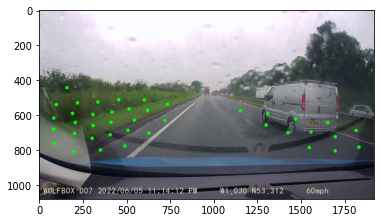

In [7]:
#plot clustered points
plotted_im = image.copy()
for i in range(0,len(x)):
    cv2.circle(plotted_im, (int(x[i]),int(y[i])), radius=10, color=(0, 255, 0), thickness=-1)
    
plt.imshow(plotted_im)

In [8]:
input_point = np.array([[i,j] for i,j in zip(x,y)])
input_label = np.array([1]*len(x))


masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

mask_input = masks[np.argmax(scores), :, :]  # Choose the model's best mask

In [9]:
mask_input

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [10]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=300):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

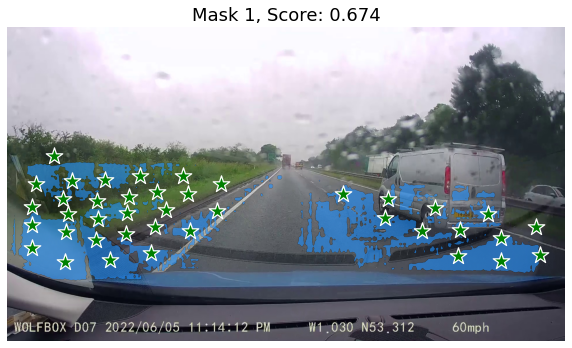

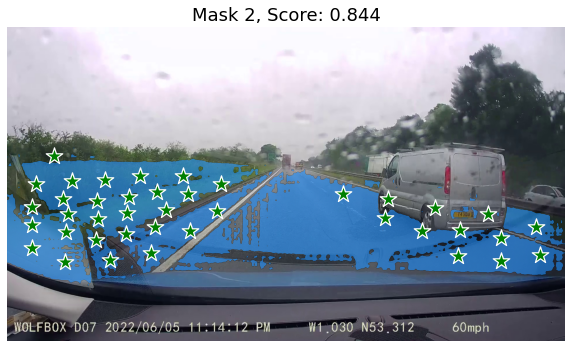

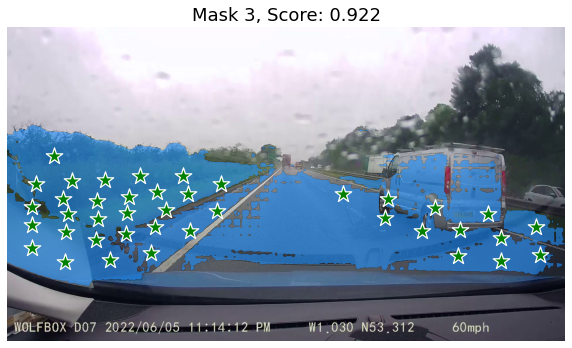

In [11]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show() 

In [12]:
mask3 = np.squeeze(mask_input)

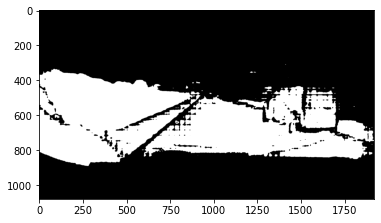

In [13]:
plt.imshow(mask3,cmap = 'gray')

In [14]:
#takes x and y centers from entire dataset
def reduce_points(centx,centy,k=15):
    points = [(centx[j], centy[j]) for j in range(0, len(centx))]

    #perform k-means to reduce 
    kmeans = KMeans(n_clusters=k, random_state=0).fit(points)


    kCents = kmeans.cluster_centers_
    x,y = zip(*kCents) #disconnect points from tuple
    
    return x,y

def SAM_segment(rgb_image, kmpx,kmpy, predictor):
    ##get all litter points as tuple
    
    predictor.set_image(rgb_image)
    input_point = np.array([[i*rgb_image.shape[1],j*rgb_image.shape[0]] for i,j in zip(kmpx,kmpy)])
    input_label = np.array([1]*len(kmpx))    
    
    masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
    )

    best_mask = masks[np.argmax(scores), :, :]  # Choose the model's best mask
    bin_mask = best_mask.astype(int)
    return bin_mask

def evaluate_segment(seg,gt,prnt = False):
    seg = np.asarray(seg).astype(bool)
    gt = np.asarray(gt).astype(bool)
    intersection = np.logical_and(seg, gt)
    union = np.logical_or(seg, gt)
    
    #DICE
    dice = 2. * np.sum(intersection) / (np.sum(seg) + np.sum(gt))

    #IOU

    iou_score = np.sum(intersection) / np.sum(union)
    if prnt == True:
        print('IoU similarity score is {}'.format(iou_score))
        print('Dice similarity score is {}'.format(dice))
    return dice, iou_score

def format_gt(gt_mask_im):
    gt_mask = cv2.cvtColor(gt_mask_im, cv2.COLOR_BGR2GRAY)
    (thresh, gt_bw) = cv2.threshold(gt_mask, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)#convert mask to grayscale
    return gt_bw

In [15]:
#test functions for image
gt_dir = r"/workspace/gvData/SegmentationClass"
gt_1 = os.path.join(gt_dir,os.listdir(gt_dir)[0])
gt_mask = cv2.imread(gt_1)
m = format_gt(gt_mask)

x,y = reduce_points(centx,centy)
test = SAM_segment(image,x,y, predictor)

(dice, iou_score) = evaluate_segment(test,m, True)

IoU similarity score is 0.33213932508382177
Dice similarity score is 0.49865553674413554


In [16]:
from tqdm import tqdm
#Perform over all dataset
samples = r'/workspace/gvData/segSamps/gv_seg'

samp_fs = os.listdir(samples)
mask_fs = os.listdir(gt_dir)

ious = []
dices = []

x,y = reduce_points(centx,centy,40)

for i in tqdm(range(0,len(samp_fs))):
    im_p = os.path.join(samples,samp_fs[i])
    gt_name = samp_fs[i].replace(".jpg",".png")

    gt_p = os.path.join(gt_dir,gt_name)
    
    im = cv2.imread(im_p)
    
    #format full image

    segged = SAM_segment(im,x,y,predictor)
    
    #format mask
    gt_mask = cv2.imread(gt_p)
    m = format_gt(gt_mask)

    (dice, iou_score) = evaluate_segment(segged,m)
    

    ious.append(iou_score)
    dices.append(dice)
    
print("Average IOU: ", np.mean(ious))
print("Average Dice: ", np.mean(dices))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.38it/s]

Average IOU:  0.2830300043263179
Average Dice:  0.4291140652021328


<BarContainer object of 40 artists>

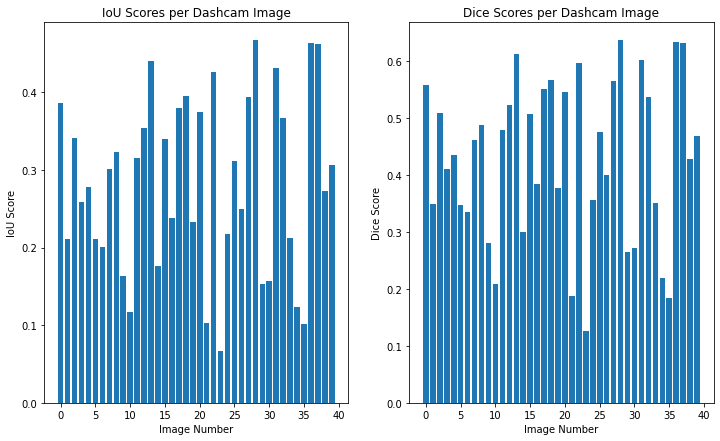

In [17]:
plt.figure(figsize=(12, 7))
h = range(0,len(ious))
plt.subplot(1,2,1)
plt.title("IoU Scores per Dashcam Image")
plt.xlabel("Image Number")
plt.ylabel("IoU Score")
plt.bar(h,ious)

plt.subplot(1,2,2)
plt.title("Dice Scores per Dashcam Image")
plt.xlabel("Image Number")
plt.ylabel("Dice Score")
plt.bar(h,dices)

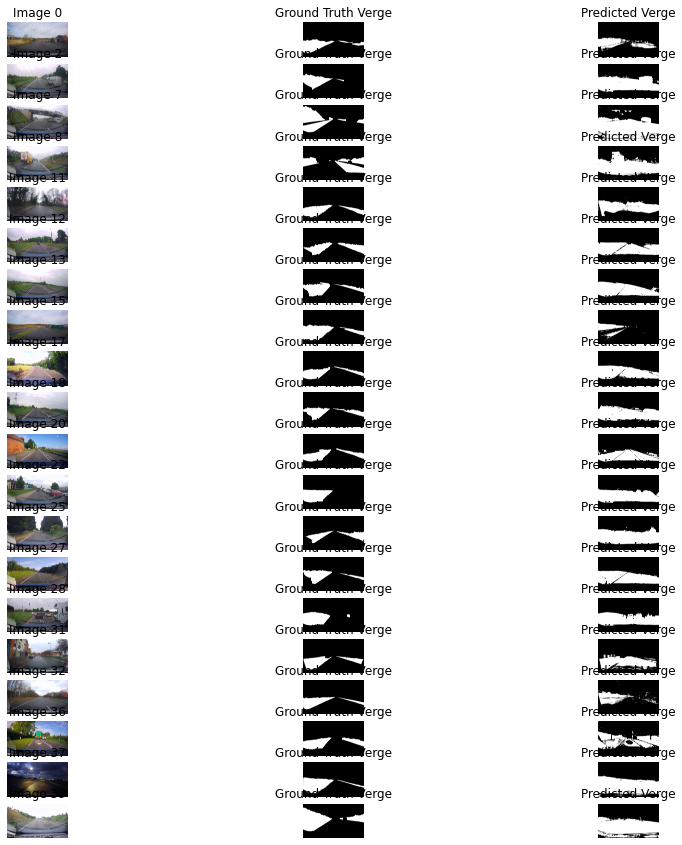

In [18]:
#Show Images where IoU is over 0.3 (Best)
plt.figure(figsize=(15, 15))

x,y = reduce_points(centx,centy)

n_dices = []
indexs = []

#find indexes
for i, u in enumerate(ious):
    if u > 0.3:
        indexs.append(i)

pic_indexer = 1

#Print their ground truth masks and relevant images
for i in range(0,len(indexs)):
    im_p = os.path.join(samples,samp_fs[indexs[i]])
    gt_name = samp_fs[indexs[i]].replace(".jpg",".png")
    gt_p = os.path.join(gt_dir,gt_name)
    
    im = cv2.imread(im_p)
    #format full image

    segged = SAM_segment(im,x,y,predictor)
    
    #format mask
    gt_mask = cv2.imread(gt_p)
    m = format_gt(gt_mask)
    
    plt.subplot(len(indexs),3,pic_indexer)
    plt.axis('off')
    plt.title(f"Image {indexs[i]}")
    plt.imshow(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))
    
    pic_indexer+=1
    
    plt.subplot(len(indexs),3,pic_indexer)
    plt.axis('off')
    plt.title("Ground Truth Verge")
    plt.imshow(m,cmap = "gray")
    
    pic_indexer+=1
    
    plt.subplot(len(indexs),3,pic_indexer)
    plt.axis('off')
    plt.title("Predicted Verge")
    plt.imshow(segged,cmap = "gray")
    
    pic_indexer+=1

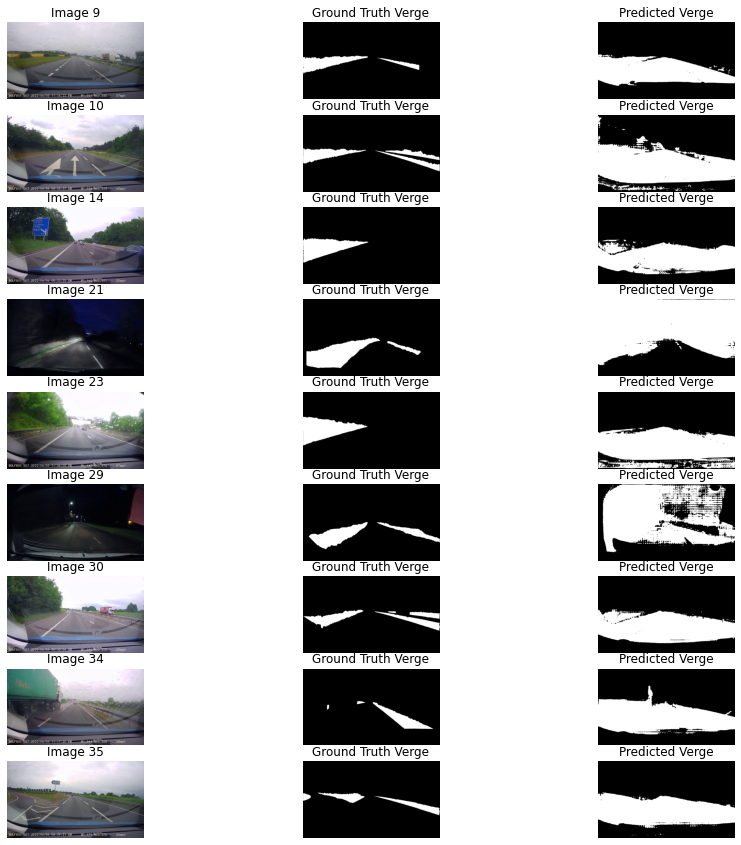

In [19]:
#Show Images where IoU less than 0.2 (Worst)
plt.figure(figsize=(15, 15))

x,y = reduce_points(centx,centy)

n_dices = []
indexs = []

#find indexes
for i, u in enumerate(ious):
    if u < 0.2:
        indexs.append(i)

pic_indexer = 1

#Print their ground truth masks and relevant images
for i in range(0,len(indexs)):
    im_p = os.path.join(samples,samp_fs[indexs[i]])
    gt_name = samp_fs[indexs[i]].replace(".jpg",".png")
    gt_p = os.path.join(gt_dir,gt_name)
    
    im = cv2.imread(im_p)
    #format full image

    segged = SAM_segment(im,x,y,predictor)
    
    #format mask
    gt_mask = cv2.imread(gt_p)
    m = format_gt(gt_mask)
    
    plt.subplot(len(indexs),3,pic_indexer)
    plt.axis('off')
    plt.title(f"Image {indexs[i]}")
    plt.imshow(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))
    
    pic_indexer+=1
    
    plt.subplot(len(indexs),3,pic_indexer)
    plt.axis('off')
    plt.title("Ground Truth Verge")
    plt.imshow(m,cmap = "gray")
    
    pic_indexer+=1
    
    plt.subplot(len(indexs),3,pic_indexer)
    plt.axis('off')
    plt.title("Predicted Verge")
    plt.imshow(segged,cmap = "gray")
    
    pic_indexer+=1

In [24]:
#Try for varying values of k
ks = [20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45]

from tqdm import tqdm
#Perform over all dataset
samples = r'/workspace/gvData/segSamps/gv_seg'

samp_fs = os.listdir(samples)
mask_fs = os.listdir(gt_dir)
medians = []
avs = []

for k in ks:
    ious = []
    dices = []
    
    x,y = reduce_points(centx,centy,k)

    for i in tqdm(range(0,len(samp_fs))):
        im_p = os.path.join(samples,samp_fs[i])
        gt_name = samp_fs[i].replace(".jpg",".png")

        gt_p = os.path.join(gt_dir,gt_name)

        im = cv2.imread(im_p)

        #format full image

        segged = SAM_segment(im,x,y,predictor)

        #format mask
        gt_mask = cv2.imread(gt_p)
        m = format_gt(gt_mask)

        (dice, iou_score) = evaluate_segment(segged,m)


        ious.append(iou_score)
        dices.append(dice)

        av_iou = np.mean(ious)
        median_iou = np.median(ious)
        std_iou = np.std(ious)
        
        
        av_dice = np.mean(dices)
        median_dice = np.median(dices)
        std_dice = np.std(dices)
        
    print("For k value of", k)
    print("Average IOU: ", av_iou)
    print("Median IOU:", median_iou)
    print("Std Dev IOU:", std_iou)
    
    print("Average Dice: ", av_dice)
    print("Median Dice:", median_dice)
    print("Std Dev Dice:", std_dice)
    
    medians.append(median_iou)
    avs.append(av_iou)
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.37it/s]


For k value of 20
Average IOU:  0.2663468155114277
Median IOU: 0.27152265528515035
Std Dev IOU: 0.11446062734831984
Average Dice:  0.4076729282462391
Median Dice: 0.4270638100484717
Std Dev Dice: 0.14428007706952192


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.37it/s]


For k value of 21
Average IOU:  0.2651306413785752
Median IOU: 0.2739588090075624
Std Dev IOU: 0.1113870192697574
Average Dice:  0.4068045966765217
Median Dice: 0.4300871101507839
Std Dev Dice: 0.1405952335532255


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.37it/s]


For k value of 22
Average IOU:  0.26489619662256547
Median IOU: 0.276895411226082
Std Dev IOU: 0.11192526136223535
Average Dice:  0.4063776297601354
Median Dice: 0.43368826341883454
Std Dev Dice: 0.14140984905433812


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.37it/s]


For k value of 23
Average IOU:  0.26613476188729146
Median IOU: 0.27135595484053465
Std Dev IOU: 0.10912301084413169
Average Dice:  0.40856724848138537
Median Dice: 0.4268760169665754
Std Dev Dice: 0.13768870605883665


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.37it/s]


For k value of 24
Average IOU:  0.26998829148685044
Median IOU: 0.27939157449661145
Std Dev IOU: 0.10725399216844485
Average Dice:  0.4138319480041971
Median Dice: 0.4367488357151946
Std Dev Dice: 0.13492417223359549


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.37it/s]


For k value of 25
Average IOU:  0.27271838566896534
Median IOU: 0.2822014039835154
Std Dev IOU: 0.10941539519535114
Average Dice:  0.4168237419898876
Median Dice: 0.4401825713061743
Std Dev Dice: 0.13701507164824367


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.37it/s]


For k value of 26
Average IOU:  0.27328359292098636
Median IOU: 0.2801793974299591
Std Dev IOU: 0.1092209816138913
Average Dice:  0.41757100154620197
Median Dice: 0.43771661413099705
Std Dev Dice: 0.13675555233392575


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.37it/s]


For k value of 27
Average IOU:  0.2770358209054393
Median IOU: 0.2796533173912382
Std Dev IOU: 0.1119660196392781
Average Dice:  0.42169757137650893
Median Dice: 0.4370569323898111
Std Dev Dice: 0.13942626352703089


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.37it/s]


For k value of 28
Average IOU:  0.27612076626603954
Median IOU: 0.2885594506196477
Std Dev IOU: 0.1089202014219864
Average Dice:  0.4210893162530521
Median Dice: 0.4478751731539313
Std Dev Dice: 0.137121513696167


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.38it/s]


For k value of 29
Average IOU:  0.27677691534912907
Median IOU: 0.2784681587412141
Std Dev IOU: 0.10928507358748389
Average Dice:  0.4219301950328463
Median Dice: 0.43561860654559825
Std Dev Dice: 0.13635921848173935


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.37it/s]


For k value of 30
Average IOU:  0.281382903987089
Median IOU: 0.28551095701773394
Std Dev IOU: 0.11238197397022366
Average Dice:  0.42697205880375755
Median Dice: 0.44410104898210134
Std Dev Dice: 0.13973590160751198


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.38it/s]


For k value of 31
Average IOU:  0.27929407724219046
Median IOU: 0.28665745634784734
Std Dev IOU: 0.10973009610328556
Average Dice:  0.42502211517739424
Median Dice: 0.445584533857655
Std Dev Dice: 0.13602843776787577


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.37it/s]


For k value of 32
Average IOU:  0.2841804460425257
Median IOU: 0.2945424440255974
Std Dev IOU: 0.1139877863772001
Average Dice:  0.43007738301143067
Median Dice: 0.4547940588504148
Std Dev Dice: 0.14149166434841984


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.38it/s]


For k value of 33
Average IOU:  0.2804736193759661
Median IOU: 0.27744781629822285
Std Dev IOU: 0.11265867580079647
Average Dice:  0.4257647669234621
Median Dice: 0.4343707024009374
Std Dev Dice: 0.1404914347637941


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.38it/s]


For k value of 34
Average IOU:  0.2792397075977761
Median IOU: 0.2853696535181906
Std Dev IOU: 0.10992830907007456
Average Dice:  0.42480068938648924
Median Dice: 0.44398813854974345
Std Dev Dice: 0.1375090910072011


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.37it/s]


For k value of 35
Average IOU:  0.2795007827191071
Median IOU: 0.2793532451553941
Std Dev IOU: 0.11012905445072581
Average Dice:  0.4251172196392778
Median Dice: 0.43671009549136
Std Dev Dice: 0.13729234438957463


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.37it/s]


For k value of 36
Average IOU:  0.28266203780569477
Median IOU: 0.2922704250136583
Std Dev IOU: 0.11155716196002487
Average Dice:  0.4287389389455026
Median Dice: 0.4521759486422504
Std Dev Dice: 0.13853760240699103


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.37it/s]


For k value of 37
Average IOU:  0.2814787488203302
Median IOU: 0.28797253457471184
Std Dev IOU: 0.11101358005279145
Average Dice:  0.4273203367621298
Median Dice: 0.4470908683272774
Std Dev Dice: 0.13880606425109826


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.38it/s]


For k value of 38
Average IOU:  0.2835949424827913
Median IOU: 0.2849527084743434
Std Dev IOU: 0.11289211264140891
Average Dice:  0.42958461741442866
Median Dice: 0.4435190494919294
Std Dev Dice: 0.1402936748565382


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.37it/s]


For k value of 39
Average IOU:  0.28674633026000135
Median IOU: 0.2890428946995972
Std Dev IOU: 0.1124918743207116
Average Dice:  0.43359044419094905
Median Dice: 0.4484403692286306
Std Dev Dice: 0.13896977571426283


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.38it/s]


For k value of 40
Average IOU:  0.2830300043263179
Median IOU: 0.2894041807561792
Std Dev IOU: 0.11163727314646853
Average Dice:  0.4291140652021328
Median Dice: 0.44877991544137763
Std Dev Dice: 0.13930914713556872


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.38it/s]


For k value of 41
Average IOU:  0.28376880543483074
Median IOU: 0.29139811370569835
Std Dev IOU: 0.1106315461787458
Average Dice:  0.4303173088327612
Median Dice: 0.45127812637132325
Std Dev Dice: 0.13710427203807743


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.38it/s]


For k value of 42
Average IOU:  0.28482702117050984
Median IOU: 0.2867060947657055
Std Dev IOU: 0.11065697382294738
Average Dice:  0.4315602966850582
Median Dice: 0.4455804945267403
Std Dev Dice: 0.13760563870694167


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.37it/s]


For k value of 43
Average IOU:  0.28491805275236726
Median IOU: 0.29064770201863654
Std Dev IOU: 0.10988042278283
Average Dice:  0.43184354430796407
Median Dice: 0.4503091838731083
Std Dev Dice: 0.13658753133917165


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.37it/s]


For k value of 44
Average IOU:  0.2827622075775218
Median IOU: 0.2894759097098839
Std Dev IOU: 0.10916828838672481
Average Dice:  0.42934501686122123
Median Dice: 0.4489472406829229
Std Dev Dice: 0.13581835345683246


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.38it/s]

For k value of 45
Average IOU:  0.2857178024187809
Median IOU: 0.2943462420476006
Std Dev IOU: 0.10992465822538376
Average Dice:  0.43285290638889806
Median Dice: 0.4548054283065121
Std Dev Dice: 0.13610791535352212


Text(0, 0.5, 'Median IOU')

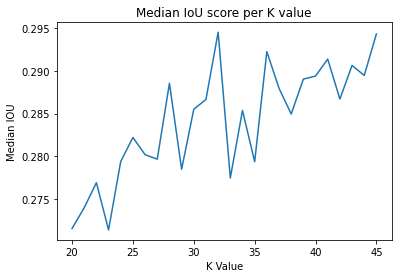

In [27]:
plt.plot(ks,medians)
plt.title("Median IoU score per K value")
plt.xlabel("K Value")
plt.ylabel("Median IOU")

Text(0, 0.5, 'Average IOU')

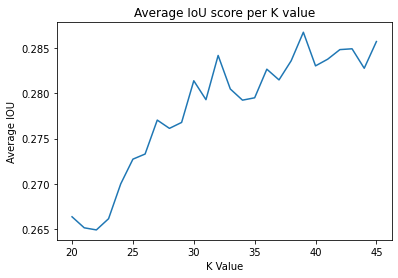

In [29]:
plt.plot(ks,avs)
plt.title("Average IoU score per K value")
plt.xlabel("K Value")
plt.ylabel("Average IOU")

In [22]:
#Plot fpr more ks...